# Imports

In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np

import os
import hashlib
import random
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import time
import copy
from tqdm import tqdm

# Data Preprocessing and Visualization: Places365

Places365 is located in /datasets-2/places365/places365_standard/train 

In this directory, there are a number of subdirectories for each class. Within each subdirectory are jpgs of the actual images comprising the dataset. 

In order to use this large dataset on DSMLP and get around the disk quota of 10GB per user, we have to create a custom dataloader and dataset. This is because of our requirements of the dataset: divide the train data into training, validation, and testing datasets, and apply masking to the individual images so that they can be fed into the context encoder.

In [72]:
class Places365Dataset(Dataset):
    def __init__(self, root, file_list, transform=None):
        self.root = root
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root, self.file_list[idx])
        image = Image.open(img_name).convert('RGB')
        label = img_name.split('/')[5]

        original = image

        if self.transform:
            original = self.transform(original)
        
        masked, true_center = self.mask_center_region(original)
        
        return masked, true_center, original, label
    
    def mask_center_region(self, image):
#         width, height = image.size
#         #fill = np.mean(np.asarray(image), axis=(0, 1))
        
#         square_size = min(height, width) // 3 
#         start_x = (width - square_size) // 2
#         end_x = start_x + square_size
#         start_y = (height - square_size) // 2
#         end_y = start_y + square_size
        
#         #mask = np.full((width, height, 3), 255, dtype = np.uint8)
#         #cv2.rectangle(mask, (start_x, start_y), (end_x, end_y), fill, -1)

#         masked_image = np.asarray(image).copy()
#         masked_image[start_y:end_y, start_x:end_x, 0] = 117.0
#         masked_image[start_y:end_y, start_x:end_x, 1] = 104.0
#         masked_image[start_y:end_y, start_x:end_x, 2] = 123.0
#         true_center = np.asarray(image)[start_y:end_y, start_x:end_x]
#         return masked_image, true_center
        masked_image = image[:].clone()
        masked_image[0, 32+4:96-4, 32+4:96-4] = 2*117.0/255.0 - 1.0
        masked_image[1, 32+4:96-4, 32+4:96-4] = 2*104.0/255.0 - 1.0
        masked_image[2, 32+4:96-4, 32+4:96-4] = 2*123.0/255.0 - 1.0
        true_center = image[:, 32:96, 32:96]
        
        return masked_image, true_center

In [74]:
dataset_root = '/datasets-2/places365/places365_standard'
train_txt_file = os.path.join(dataset_root, 'train.txt')

# Open the text file in read mode
with open(train_txt_file, 'r') as file:
    num_lines = sum(1 for line in file)

print("Number of image names in the train.txt:", num_lines)

# Read the content of train.txt and val.txt files
def read_file(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    return [line.strip() for line in lines]

train_files = read_file(train_txt_file)

# Shuffle the filenames to randomize the order
random.shuffle(train_files)

# Split the dataset into training and testing subsets
train_split_ratio = 0.7
val_split_ratio = 0.2
test_split_ratio = 0.1
num_train_samples = int(len(train_files) * train_split_ratio)
num_val_samples = int(len(train_files) * val_split_ratio)
num_test_samples = int(len(train_files) * test_split_ratio)
train_subset = train_files[:num_train_samples]
val_subset = train_files[num_train_samples:(num_train_samples+num_val_samples)]
test_subset = train_files[(num_train_samples+num_val_samples):]

# Define transformations for data preprocessing
train_transform = T.Compose([
    T.ToTensor(),
    T.Resize((128,128), antialias=True),
])

# Create train, val, test datasets
batch_size= 64

train_dataset = Places365Dataset(dataset_root, train_subset, transform=train_transform)
val_dataset = Places365Dataset(dataset_root, val_subset, transform=train_transform)
test_dataset = Places365Dataset(dataset_root, test_subset, transform=train_transform)

places365_train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2)
places365_val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)
places365_test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2)

print("Number of images in the places365_train_loader:", len(places365_train_loader) * batch_size)
print("Number of images in the places365_val_loader:", len(places365_val_loader) * batch_size)

Number of image names in the train.txt: 1803460
Number of batches in the places365_train_loader: 19726
Number of batches in the places365_val_loader: 5636


torch.Size([64, 3, 128, 128]) torch.Size([64, 3, 64, 64]) torch.Size([64, 3, 128, 128])
Masked Image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


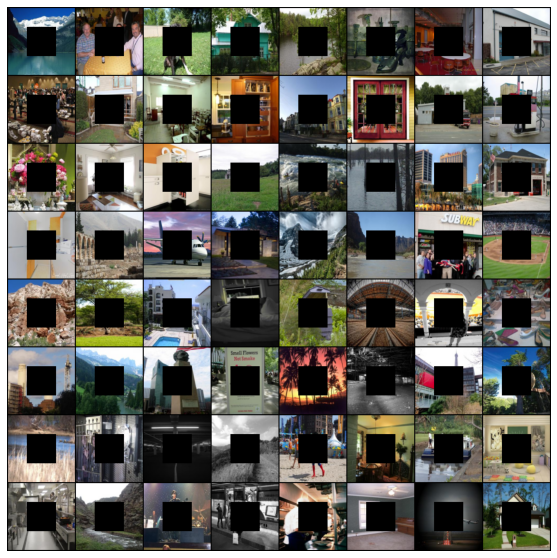

True Center


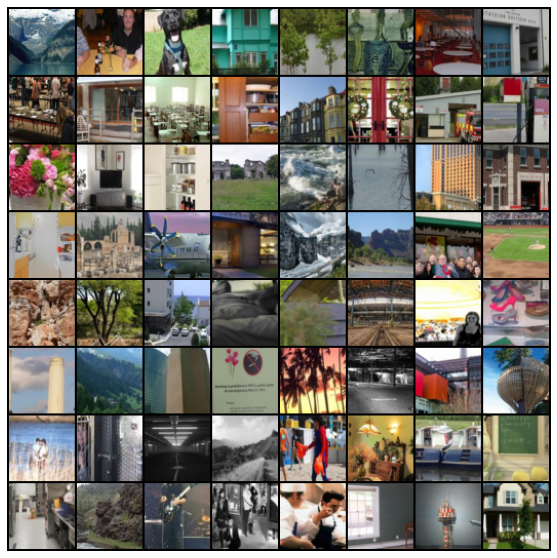

Original Image


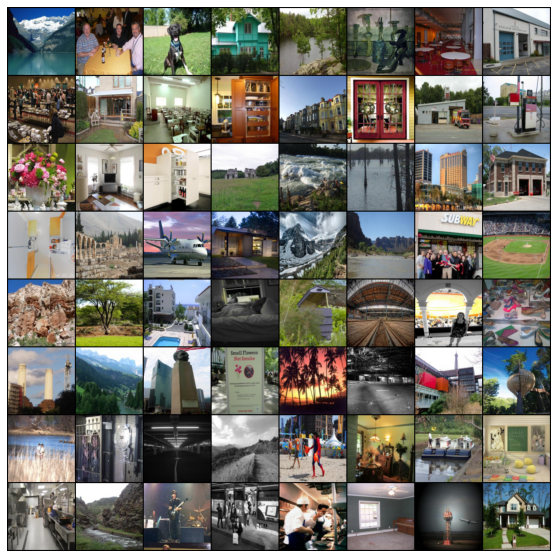

Image Name ('lake-natural', 'beer_hall', 'lawn', 'inn-outdoor', 'lake-natural', 'museum-indoor', 'cafeteria', 'fire_station', 'bookstore', 'roof_garden', 'classroom', 'pantry', 'apartment_building-outdoor', 'doorway-outdoor', 'fire_station', 'gas_station', 'florist_shop-indoor', 'television_room', 'pantry', 'ruin', 'watering_hole', 'marsh', 'hotel-outdoor', 'fire_station', 'utility_room', 'ruin', 'heliport', 'yard', 'glacier', 'raft', 'fastfood_restaurant', 'baseball_field', 'badlands', 'tree_farm', 'inn-outdoor', 'hotel_room', 'greenhouse-outdoor', 'arena-rodeo', 'bullring', 'shoe_shop', 'industrial_area', 'valley', 'office_building', 'ticket_booth', 'coast', 'parking_garage-indoor', 'building_facade', 'tree_house', 'marsh', 'bank_vault', 'parking_garage-indoor', 'forest_path', 'volleyball_court-outdoor', 'dining_hall', 'canal-natural', 'kindergarden_classroom', 'restaurant_kitchen', 'river', 'arena-performance', 'bus_station-indoor', 'restaurant_kitchen', 'bow_window-indoor', 'runway

In [75]:
masked, true_center, original, image_name = next(iter(places365_train_loader))
print(masked.shape, true_center.shape, original.shape)

def display_samples(image):
    npimg = image.numpy()
    plt.figure(figsize = (10, 10))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

print('Masked Image')
display_samples(torchvision.utils.make_grid(masked))
print('True Center')
display_samples(torchvision.utils.make_grid(true_center))
print('Original Image')
display_samples(torchvision.utils.make_grid(original))
print('Image Name', image_name)

# Context Encoder Architecture

In [76]:
class ContextEncoder(nn.Module):
    def __init__(self, in_channels=3, bottleneck_channels=2048):
        super(ContextEncoder, self).__init__()
        
        #My code
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        #self.conv_bottleneck = nn.Conv2d(512, bottleneck_channels, kernel_size=4, stride=1, padding=0)
        
        self.conv_bottleneck = nn.Sequential(
            nn.Conv2d(512, bottleneck_channels, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(bottleneck_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv_bottleneck(x)
        return x

In [77]:
class ContextDecoder(nn.Module):
    def __init__(self, bottleneck_channels=2048, out_channels=3):
        super(ContextDecoder, self).__init__()
        
        #My code
        self.transpose_conv1 = nn.Sequential(
            nn.ConvTranspose2d(bottleneck_channels, 512, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        
        self.transpose_conv2 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        self.transpose_conv3 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        
        self.transpose_conv4 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        self.transpose_conv5 = nn.ConvTranspose2d(64, out_channels, kernel_size=4, stride=2, padding=1, bias=False)
        
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.transpose_conv1(x)
        x = self.transpose_conv2(x)
        x = self.transpose_conv3(x)
        x = self.transpose_conv4(x)
        x = self.transpose_conv5(x)
        x = self.tanh(x)
        return x

In [78]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, bottleneck_channels=2048):
        super(Generator, self).__init__()
        
        self.context_encoder = ContextEncoder(in_channels=in_channels, bottleneck_channels=bottleneck_channels)
        
        self.context_decoder = ContextDecoder(bottleneck_channels=bottleneck_channels, out_channels=in_channels)
        
    def forward(self, x):
        encoder_output = self.context_encoder(x)
        decoder_output = self.context_decoder(encoder_output)
        return decoder_output
        

In [79]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.fc5 = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0)
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.fc5(x)
        x = self.sigmoid(x)
        return x

# Training

In [80]:
def store_weights(generator, discriminator, root = "./weights/"):
    if not os.path.exists(root):
        os.makedirs(root)
    torch.save(generator.state_dict(), root + "generator")
    torch.save(discriminator.state_dict(), root + "discriminator")

def load_models(root = "./weights/"):
    generator = Generator(in_channels=3, bottleneck_channels=2048)
    discriminator = Discriminator(in_channels=3)
    
    if not os.path.exists(root):
        generator.load_state_dict(torch.load(root + "generator"))
        discriminator.load_state_dict(torch.load(root + "discriminator"))
    
    return generator, discriminator

In [81]:
def train(generator, discriminator, epochs, batch_size, learning_rate, betas, train_loader):  
    
    generator.to(device)
    discriminator.to(device)
    
    optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=betas)
    optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=betas)
    
    loss_func_BCE = nn.BCELoss()
    #loss_func_MSE = nn.MSELoss()
    
    loss_func_BCE.to(device)
    #loss_func_MSE.to(device)
    
    #Set learning rates for our total loss
    weight_reconstruction = 0.999
    weight_adversarial = 0.001
    
    for i in range(epochs):
        
        total_loss = 0.0
        num_samples = 0
        start_time = time.time()
        
        generator.zero_grad()
        generator.train()
        discriminator.zero_grad()
        discriminator.train()
        
        for batch_idx, (masked, true_center, original, label) in tqdm(enumerate(train_loader), total=len(train_loader)):
            masked, true_center, original = masked.to(device), true_center.to(device), original.to(device)
            curr_batch_size = masked.size(0)
            real_labels = torch.ones((curr_batch_size, 1, 1, 1)).to(device)
            fake_labels = torch.zeros((curr_batch_size, 1, 1, 1)).to(device)
            
            #Discriminator
            optimizer_D.zero_grad()
            
            #Train with real
            discriminator_real_output = discriminator(true_center)
            discriminator_real_loss = loss_func_BCE(discriminator_real_output, real_labels)
            
            #Train with fake
            generator_output = generator(masked)
            discriminator_fake_output = discriminator(generator_output.detach())
            discriminator_fake_loss = loss_func_BCE(discriminator_fake_output, fake_labels)
            
            discriminator_total_loss = discriminator_real_loss + discriminator_fake_loss
            discriminator_total_loss.backward()
            optimizer_D.step()
            
            #Adversarial Loss
            discriminator_fake_output = discriminator(generator_output)
            adversarial_loss = loss_func_BCE(discriminator_fake_output, real_labels)
            
            #Generator
            optimizer_G.zero_grad()
            
            loss_weights = torch.ones(generator_output.size()).to(device)
            
            #reconstruction_loss = loss_func_MSE(fake, true_center, loss_weights)
            reconstruction_loss = torch.mean(loss_weights * (generator_output - true_center).pow(2))
            generator_total_loss = weight_reconstruction * reconstruction_loss + weight_adversarial * adversarial_loss

            generator_total_loss.backward()
            optimizer_G.step()
            
            #Metrics / Save weights every 2000 batches
            
            total_loss += generator_total_loss.item() * curr_batch_size
            num_samples += curr_batch_size
            
            if batch_idx % 1999 == 0:
                store_weights(generator, discriminator, root = "./weights/")
                
                correct_real = (discriminator_real_output > 0.5).sum().item()
                correct_fake = (discriminator_fake_output <= 0.5).sum().item()
                total_real = real_labels.size(0)
                total_fake = fake_labels.size(0)

                accuracy_real = correct_real / total_real
                accuracy_fake = correct_fake / total_fake

                end_time = time.time()
                execution_time = end_time - start_time
                print('Batch %d | Epoch Loss: %.4f | D(Real) Acc.: %.4f | D(Fake) Acc.: %.4f | Execution Time: %.4f' 
                      % (batch_idx+1, total_loss/num_samples, accuracy_real, accuracy_fake, execution_time))
            
        store_weights(generator, discriminator, root = "./weights/")
        end_time = time.time()
        execution_time = end_time - start_time
        print('Epoch %d | Context-Encoder Loss: %.4f | Execution Time: %.4f' % (i+1, total_loss/num_samples, execution_time))
    
    

In [82]:
USE_GPU = True
dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print("Using device ", device)

epochs = 3
learning_rate = 0.0002
betas = (0.5, 0.999)

generator, discriminator = load_models()
train(generator=generator, discriminator=discriminator, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate, betas=betas, train_loader=places365_train_loader)

Using device  cuda


  0%|          | 2/19726 [00:01<2:27:37,  2.23it/s]

Processed 1 batches, epoch loss: 0.6552798748016357


  5%|▌         | 1002/19726 [02:18<1:16:36,  4.07it/s]

Processed 1001 batches, epoch loss: 0.05001380701328848


 10%|█         | 2002/19726 [04:35<1:11:44,  4.12it/s]

Processed 2001 batches, epoch loss: 0.046123203482182844


 15%|█▌        | 3002/19726 [06:54<1:08:21,  4.08it/s]

Processed 3001 batches, epoch loss: 0.04439244940206632


 20%|██        | 4002/19726 [09:22<1:04:37,  4.06it/s]

Processed 4001 batches, epoch loss: 0.04345382952732582


 25%|██▌       | 5002/19726 [12:20<1:12:04,  3.40it/s]

Processed 5001 batches, epoch loss: 0.042940113796273174


 30%|███       | 6002/19726 [16:00<1:17:57,  2.93it/s]

Processed 6001 batches, epoch loss: 0.04260410498092074


 35%|███▌      | 7002/19726 [21:32<1:41:08,  2.10it/s]

Processed 7001 batches, epoch loss: 0.04239422657870638


 41%|████      | 8001/19726 [29:21<2:01:31,  1.61it/s]

Processed 8001 batches, epoch loss: 0.04222872834119547


 46%|████▌     | 9002/19726 [37:46<1:39:05,  1.80it/s]

Processed 9001 batches, epoch loss: 0.042170348803487606


 51%|█████     | 10002/19726 [46:06<1:30:42,  1.79it/s]

Processed 10001 batches, epoch loss: 0.04195742967062957


 56%|█████▌    | 11002/19726 [54:18<1:16:15,  1.91it/s]

Processed 11001 batches, epoch loss: 0.04186554617757186


 61%|██████    | 12002/19726 [1:02:30<1:07:37,  1.90it/s]

Processed 12001 batches, epoch loss: 0.041789656491175206


 66%|██████▌   | 13001/19726 [1:10:52<1:09:26,  1.61it/s]

Processed 13001 batches, epoch loss: 0.041725528809785584


 71%|███████   | 14002/19726 [1:19:18<54:25,  1.75it/s]  

Processed 14001 batches, epoch loss: 0.04168646225585877


 76%|███████▌  | 15002/19726 [1:27:41<40:54,  1.92it/s]  

Processed 15001 batches, epoch loss: 0.04159724343704423


 81%|████████  | 16001/19726 [1:36:11<36:33,  1.70it/s]

Processed 16001 batches, epoch loss: 0.041536307914123057


 86%|████████▌ | 17002/19726 [1:44:53<24:24,  1.86it/s]

Processed 17001 batches, epoch loss: 0.04150426064943711


 91%|█████████▏| 18002/19726 [1:53:33<16:12,  1.77it/s]

Processed 18001 batches, epoch loss: 0.041469247971870564


 96%|█████████▋| 19002/19726 [2:02:17<06:54,  1.75it/s]

Processed 19001 batches, epoch loss: 0.04139516790784238


100%|██████████| 19726/19726 [2:08:33<00:00,  2.56it/s]


Epoch [1/3], Context Encoder Loss: 0.0414


  0%|          | 2/19726 [00:01<2:34:46,  2.12it/s]

Processed 1 batches, epoch loss: 0.04619132727384567


  5%|▌         | 1002/19726 [08:32<2:29:01,  2.09it/s]

Processed 1001 batches, epoch loss: 0.040287163891977486


 10%|█         | 2002/19726 [16:57<2:49:49,  1.74it/s]

Processed 2001 batches, epoch loss: 0.040503592316483865


 15%|█▌        | 3001/19726 [25:29<2:33:26,  1.82it/s]

Processed 3001 batches, epoch loss: 0.04058683431163922


 20%|██        | 4002/19726 [34:01<2:14:07,  1.95it/s]

Processed 4001 batches, epoch loss: 0.04048199428143471


 25%|██▌       | 5002/19726 [42:31<1:59:58,  2.05it/s]

Processed 5001 batches, epoch loss: 0.0404794432511123


 30%|███       | 6002/19726 [51:04<2:08:16,  1.78it/s]

Processed 6001 batches, epoch loss: 0.04037062719047139


 35%|███▌      | 7002/19726 [59:35<1:58:13,  1.79it/s]

Processed 7001 batches, epoch loss: 0.04038636333981832


 41%|████      | 8001/19726 [1:08:04<1:57:37,  1.66it/s]

Processed 8001 batches, epoch loss: 0.04032734030276377


 46%|████▌     | 9001/19726 [1:16:41<1:50:02,  1.62it/s]

Processed 9001 batches, epoch loss: 0.04031956607719856


 51%|█████     | 10002/19726 [1:25:15<1:18:43,  2.06it/s]

Processed 10001 batches, epoch loss: 0.04033032153779543


 56%|█████▌    | 11001/19726 [1:33:49<1:33:41,  1.55it/s]

Processed 11001 batches, epoch loss: 0.04028265969163206


 61%|██████    | 12002/19726 [1:42:25<1:14:49,  1.72it/s]

Processed 12001 batches, epoch loss: 0.04028308117986793


 66%|██████▌   | 13001/19726 [1:50:57<1:10:22,  1.59it/s]

Processed 13001 batches, epoch loss: 0.040291253791811255


 71%|███████   | 14002/19726 [1:57:45<22:46,  4.19it/s]  

Processed 14001 batches, epoch loss: 0.04035864021429806


 76%|███████▌  | 15002/19726 [2:00:00<19:10,  4.11it/s]

Processed 15001 batches, epoch loss: 0.0403331484131301


 81%|████████  | 16002/19726 [2:02:15<16:24,  3.78it/s]

Processed 16001 batches, epoch loss: 0.0403018766194284


 86%|████████▌ | 17002/19726 [2:04:30<10:51,  4.18it/s]

Processed 17001 batches, epoch loss: 0.04032743662314396


 91%|█████████▏| 18002/19726 [2:06:44<07:26,  3.86it/s]

Processed 18001 batches, epoch loss: 0.040327987728273


 96%|█████████▋| 19002/19726 [2:08:58<02:53,  4.16it/s]

Processed 19001 batches, epoch loss: 0.0403108722791307


100%|██████████| 19726/19726 [2:10:36<00:00,  2.52it/s]


Epoch [2/3], Context Encoder Loss: 0.0403


  0%|          | 2/19726 [00:01<2:42:35,  2.02it/s]

Processed 1 batches, epoch loss: 0.0387563481926918


  5%|▌         | 1002/19726 [02:15<1:13:52,  4.22it/s]

Processed 1001 batches, epoch loss: 0.040185487188108555


 10%|█         | 2002/19726 [04:30<1:16:17,  3.87it/s]

Processed 2001 batches, epoch loss: 0.04019422190955494


 15%|█▌        | 3002/19726 [06:46<1:09:38,  4.00it/s]

Processed 3001 batches, epoch loss: 0.040381676569873994


 20%|██        | 4002/19726 [09:01<1:02:00,  4.23it/s]

Processed 4001 batches, epoch loss: 0.04030193754054477


 25%|██▌       | 5002/19726 [11:18<59:17,  4.14it/s]  

Processed 5001 batches, epoch loss: 0.04024455796050456


 30%|███       | 6002/19726 [13:35<56:10,  4.07it/s]  

Processed 6001 batches, epoch loss: 0.0401746399736026


 35%|███▌      | 7002/19726 [15:52<54:21,  3.90it/s]  

Processed 7001 batches, epoch loss: 0.040126889518389885


 41%|████      | 8002/19726 [18:08<47:44,  4.09it/s]

Processed 8001 batches, epoch loss: 0.04008521881420573


 46%|████▌     | 9002/19726 [20:24<42:39,  4.19it/s]

Processed 9001 batches, epoch loss: 0.040049959709579155


 51%|█████     | 10002/19726 [22:39<39:04,  4.15it/s]

Processed 10001 batches, epoch loss: 0.04005709950206024


 56%|█████▌    | 11002/19726 [24:54<34:00,  4.28it/s]

Processed 11001 batches, epoch loss: 0.04005123845658571


 61%|██████    | 12002/19726 [27:09<30:22,  4.24it/s]

Processed 12001 batches, epoch loss: 0.040024461946700444


 66%|██████▌   | 13002/19726 [29:24<28:32,  3.93it/s]

Processed 13001 batches, epoch loss: 0.04002042793330046


 71%|███████   | 14002/19726 [31:39<25:10,  3.79it/s]

Processed 14001 batches, epoch loss: 0.04000258323332789


 76%|███████▌  | 15002/19726 [33:55<18:59,  4.15it/s]

Processed 15001 batches, epoch loss: 0.039995025700216104


 81%|████████  | 16002/19726 [36:10<15:10,  4.09it/s]

Processed 16001 batches, epoch loss: 0.040004167092187494


 86%|████████▌ | 17002/19726 [38:26<10:59,  4.13it/s]

Processed 17001 batches, epoch loss: 0.04001714807203356


 91%|█████████▏| 18002/19726 [40:41<06:52,  4.18it/s]

Processed 18001 batches, epoch loss: 0.04002501000695497


 96%|█████████▋| 19002/19726 [42:57<02:52,  4.19it/s]

Processed 19001 batches, epoch loss: 0.04001502506454523


100%|██████████| 19726/19726 [44:34<00:00,  7.38it/s]


Epoch [3/3], Context Encoder Loss: 0.0400


# Evaluation

In [ ]:
#Evaluate train loader
generator.eval()

masked, true_center, original, label = next(iter(places365_train_loader))

masked = masked.to(device)
model_output = generator(masked)

inpainted_samples = masked.clone().to(device)
inpainted_samples[:,:, 32:96, 32:96] = model_output

# def display_samples(image):
#     npimg = image.numpy()
#     plt.figure(figsize = (10, 10))
#     plt.axis('off')
#     plt.imshow(np.transpose(npimg, (1,2,0)))
#     plt.show()

print('Original Image')
display_samples(torchvision.utils.make_grid(original))
print('Model_Output')
display_samples(torchvision.utils.make_grid(inpainted_samples))



# Sid's Model

In [ ]:
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # nz: input noise dimension, ngf: size of feature maps, nc: number of output channels
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()  # Output image in range [-1, 1]
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # nc: number of input channels, ndf: size of feature maps
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()  # Output probability [0, 1]
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

In [ ]:
nz = 100
ngf = 64
ndf = 64
nc = 3

In [ ]:
netG = Generator(nz, ngf, nc)
netD = Discriminator(nc, ndf)

In [ ]:
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
criterion = nn.BCELoss()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
netG.to(device)
netD.to(device)
criterion.to(device)

In [ ]:
batch_size = 64

cifar100_train_loader = DataLoader(cifar100_train, batch_size=batch_size, shuffle=True, num_workers=2)
cifar100_val_loader = DataLoader(cifar100_val, batch_size=batch_size, shuffle=False, num_workers=2)
cifar100_test_loader = DataLoader(cifar100_test, batch_size=batch_size, shuffle=False, num_workers=2)

# places365_train_loader = DataLoader(places365_train, batch_size=batch_size, shuffle=True, num_workers=2)
# places365_val_loader = DataLoader(places365_val, batch_size=batch_size, shuffle=False, num_workers=2)
# places365_test_loader = DataLoader(places365_test, batch_size=batch_size, shuffle=False, num_workers=2)